# Signal processing and time-frequency analysis

Signal processing is a fundamental component of any neuroscientific analysis, and sadly is one of the more poorly-taught fields out there (for scientists, anyway). Basically, this is just a way of manipulating and understanding signals (usually that vary in time). In predictive modeling of language, the two signals we tend to care about are ones that come from the brain (e.g., EEG, ECoG) and ones that come from our mouths (e.g., speech, language). Signal processing is a HUGE field, and in neuroscience we usually only scratch the surface. It’s most important to be familiar with these techniques, and particularly know when it might affect your data.

> The most basic package for doing this kind of thing in python is called “[scipy.signal](http://docs.scipy.org/doc/scipy/reference/signal.html)”. It’s the “signal” submodule of the scipy package. It’s got a lot of great features, though it can be more confusing than it needs to be.

In practice, it's often easier to use signal processing tools that have been pre-crafted for neuroscience analysis. A good place to start is [MNE-python](http://martinos.org/mne/stable/mne-python.html), which has a `time_frequency` module that has many of these functions in more user-friendly form. In particular, [these are some functions](http://martinos.org/mne/stable/python_reference.html#time-frequency) that can create spectrograms of sound or brain activity. I recommend checking out their "examples gallery" [here](http://martinos.org/mne/stable/auto_examples/index.html) to get an idea for what's possible.

Of particular interest to neuroscience are "time-frequency" decompositions. Extracting the frequency content of a signal allows you to take a time-domain signal (e.g., air pressure over time) into a frequency-domain signal (e.g., frequency power over frequency value). This tells us “how much” of each frequency is in the original signal.
In neuroscience, we do this on sliding windows of a signal, and slid those windows across time (computing the frequency representation each time) in order to build a spectrogram of the signal, aka, how the frequency content changes across time.

> To perform these things on a signal, check out the "periodogram" and "specgram" functions of pyplot. Also check out the time-frequency module that I linked to earlier.

In general, you need to provide the signal itself, as well as the sampling rate of the signal (e.g., how many points per second are we recording). This lets the function know the highest frequency that can be detected in the signal.

There are often other parameters to play around with, these often correspond to the parameters for the windows, or how the Fourier Transform is performed. Play around with them and see how it changes things.

A quick note - if you've got a 3-D matrix (e.g., a spectrogram that is time x frequency x amplitude), then a useful way of visualizing is to plot it as an image (aka, time and frequency are the two sides of the image, and the color intensity is the amplitude). Check out the "imshow" function for this.

## On to the data
For a first look at time-frequency processing, we'll first look at a raw audio file. This will show us how we can extract time-frequency information from a raw waveform. Then, we'll perform the same analysis on brain activity and see what there is to learn.

In [29]:
import mne
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

/Users/choldgraf/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Read in an MNE epochs file
data = mne.io.Raw('./data/audio_clean_raw.fif', add_eeg_ref=False)

In [3]:
# Load our times file, which is stored as a CSV of events
mtime = pd.read_csv('./data/time_info.csv', index_col=0)
mtime = mtime.query('t_type=="mid" and t_num > 0')

# We will create an "events" object by turning the start times into indices
# Then turning it into an array of shape (n_events, 3)
ev = mtime['start'] * data.info['sfreq']  # goes from seconds to index
ev = np.vstack([ev, np.zeros_like(ev), np.ones_like(ev)]).astype(int).T

# This is just a metadata dictionary.
# If we had multiple event types, we'd specify here.
einfo = dict(myevent=1)

In [4]:
# Now create an epochs object so we're time-locked to sound onset
tmin, tmax = -.5, 2
epochs = mne.Epochs(data, ev, einfo, tmin, tmax,
                    baseline=(None, 0), preload=True)

# Note it's the same shape as before
print(epochs._data.shape)

(47, 1, 40001)


As you'll see below, audio is represented as changing air pressure over time. It looks like audio has structure if you look at it in raw form, but it's quite difficult to make any sense of this:

/Users/choldgraf/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:90: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:667: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


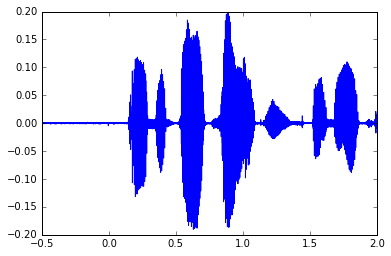

In [5]:
data_plt = epochs._data[0]
plt.plot(epochs.times, data_plt.T)

Fortunately for us, we've got a long history of audio analysis and signal processing to draw on. One thing that scientists have learned about audio is that it's actually a combination of lots of sine waves that oscillate at different frequencies. Signal processing gives us a set of tools to uncover this underlying structure in the data.

We'll use a *Morlet Wavelet* to extract the extent to which each of these sine waves contributes to the signal. A wavelet is basically a tiny "window" signal that you use as a filter for the audio waveform. The extent to which the waveform overlaps with your wavelet, the output will be larger.

So, we construct wavelets for a range of frequencies and see which are represented most strongly in the signal. Moreover, we will slide this window across our audio waveform to see how the frequency representation changes over time. This is accomplished with the `cwt_morlet` function in MNE. 

In [6]:
freqs = np.logspace(2, np.log10(5000), 128)
spec = mne.time_frequency.cwt_morlet(data_plt, epochs.info['sfreq'], freqs)

In [7]:
# Our output is now n_epochs x n_freqs x time
spec.shape

(1, 128, 40001)

/Users/choldgraf/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:3093: ComplexWarning: Casting complex values to real discards the imaginary part
  output = self._data.astype(newtype).view(type(self))
/Users/choldgraf/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:941: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin = float(vmin)
/Users/choldgraf/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:942: ComplexWarning: Casting complex values to real discards the imaginary part
  vmax = float(vmax)


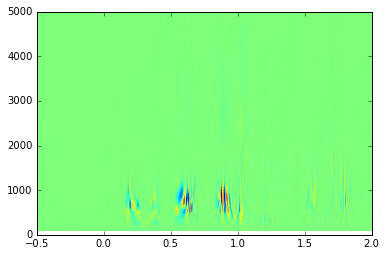

In [8]:
# And now we reveal the spectral content that was present in the sound
plt.pcolormesh(epochs.times, freqs, spec[0])

Doesn't look too clean. This is because of something called the *1/f power law*. Basically, the total power in a frequency drops off as the frequency is larger (by a factor of `1/f`). Because of this, the power at low frequencies tends to dominate our visualization. So, we can fix this by taking the log of the output:

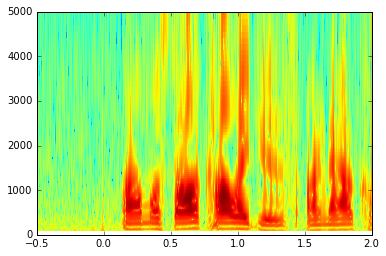

In [9]:
# Whoops, that looks pretty messy. Let's try taking the log...
f, ax = plt.subplots()
ax.pcolormesh(epochs.times, freqs, np.log(spec[0]))

Now we've revealed the underlying spectro-temporal structure that was present in the sound. By using a time-frequency decomposition, we've taken a really complicated looking time-varying signal, and we've revealed some interesting stuff that was happening under the surface. Let's do the same for our brain signal and see if we can gain similar insights.

## Brain activity

So it's clear that we can learn interesting underlying structure in sounds by taking looking at their spectral content. What about the brain? There's a long history of spectral analysis in neuroscience. This is because most signals we record from the brain also vary in time. Using the same analytical methods, we can parse apart different kinds of signal in our brain data.

In [10]:
# First we'll load some brain data
brain = mne.io.Raw('./data/ecog_clean_raw.fif', add_eeg_ref=False)

In [12]:
# We will create an "events" object by turning the start times into indices
ev = mtime['start'] * brain.info['sfreq']  # goes from seconds to index
ev = np.vstack([ev, np.zeros_like(ev), np.ones_like(ev)]).astype(int).T
einfo = dict(myevent=1)

In [13]:
# Now we have time-locked Epochs
tmin, tmax = -.5, 2
brain_epochs = mne.Epochs(brain, ev, einfo, tmin, tmax,
                          baseline=(None, 0), preload=True)

# Note it's the same shape as before
print(brain_epochs._data.shape)

(47, 64, 2501)


In [14]:
# Pull a subset of epochs to speed things up
n_ep = 10
use_epochs = np.random.choice(range(len(brain_epochs)), replace=False, size=n_ep)
brain_epochs = brain_epochs[use_epochs]

Before getting into a full fancy spectral analysis. We'll first look at the *Power Spectral Density*. This is basically a "snapshot" of spectral power for the entire trial (aka, not moving in time).

We'll use a method known as *Multitaper Spectral Estimation*. In this case, rather than using a sliding window as we did with Morlet Wavelets, we'll construct a set of filters that are all overlapping in time. These filters are constructed so that they are *orthogonal* to one another. Basically, this means that they are designed to extract different kinds of information from the signal, which in turn means that we get a more stable estimate of the spectral content in the signal.

In [15]:
# Multitaper
psd = []
for ep in brain_epochs._data:
    ipsd, freqs = mne.time_frequency.multitaper._psd_multitaper(
        ep, sfreq=brain_epochs.info['sfreq'])
    psd.append(ipsd)
psd = np.array(psd)
psd = pd.DataFrame(psd.mean(0), columns=freqs)
psd.index.name = 'elec'
psd['kind'] = 'mt'
psd.set_index('kind', append=True, inplace=True)

# Collect them
psd.columns.name = 'freq'

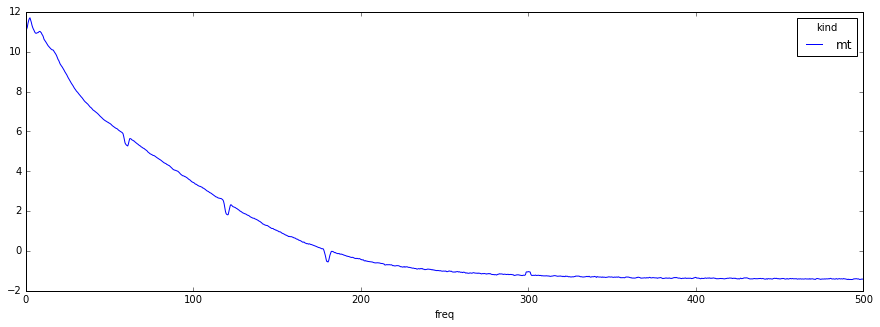

In [17]:
# Just as before, we'll apply the log and plot
psd.apply(np.log).groupby(level='kind').mean().T.plot(figsize=(15, 5))

So what can we learn from this? Well, it seems like there is more power at low frequencies (that's the `1/f` bit we covered earlier). Moreover, at some point the power seems to level off. This is known as the "noise floor" and it basically means that we can't make meaningful statements about the brain past that point.

## TFR

OK, so we've estimated the *Power Spectral Density* of the brain activity, but let's take a look at how this changes over time. For this, we can use the same method above

In [18]:
# Here we'll define the range of frequencies we care about
freqs = np.logspace(1, np.log10(150), 20)

# This determines the length of the filter we use to extract spectral content
n_cycles = 5

In [24]:
freqs.shape

(20,)

In [26]:
# Now we'll extract the TFR of our brain data
df_tfr = []
tfr, itc = mne.time_frequency.tfr_morlet(brain_epochs, freqs, n_cycles)
for i, elec in enumerate(tfr.data):
    ielec = pd.DataFrame(elec, index=freqs, columns=brain_epochs.times)
    ielec['elec'] = i
    ielec.index.name = 'freq'
    ielec.set_index(['elec'], inplace=True, append=True)
    df_tfr.append(ielec)
df_tfr = pd.concat(df_tfr, axis=0)

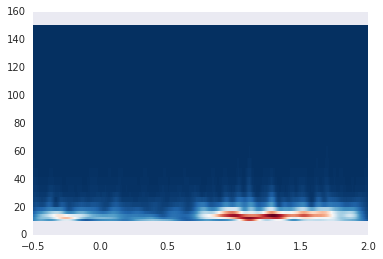

In [47]:
f, ax = plt.subplots()
plt_df = df_tfr.xs(20, level='elec')
y_axis = plt_df.index.values
# y_axis = np.arange(plt_df.shape[0])
ax.pcolormesh(plt_df.columns.values, y_axis, plt_df.values,
              cmap=plt.cm.RdBu_r)